In [ ]:
# ..... compare across datasets - MN ..... #

In [2]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(Seurat)

In [3]:
# get list of samples
stages = rep(c('stage23', 'stage28', 'stage32'), each = 3)
samples = c('sample3', 'sample4', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')
days = rep(c('D4', 'D6', 'D8'), each = 3)
combos = combn(1:length(stages),2)

In [9]:
ii = 1
id1 = combos[1,ii]
id2 = combos[2,ii]

# load data
sc1 = readRDS(paste0(stages[id1], '_', samples[id1], '_data.rds'))
sc1$dataset = paste0(days[id1], '-s', sub('\\.*sample', '', samples[id1]))
sc1$celltype = sc1$seurat_clusters
sc1$stage = days[id1]

# load data
sc2 = readRDS(paste0(stages[id2], '_', samples[id2], '_data.rds'))
sc2$dataset = paste0(days[id2], '-s', sub('\\.*sample', '', samples[id2]))
sc2$celltype = sc2$seurat_clusters
sc2$stage = days[id2]

# get metadata
cols = c('dataset', 'stage', 'celltype')
mtd1 = sc1@meta.data[,cols]
mtd2 = sc2@meta.data[,cols]
mtd0 = rbind(mtd1, mtd2)

In [12]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(GetAssayData(sc1, 'counts'), 
                                               GetAssayData(sc2, 'counts'))),
                           colData = DataFrame(mtd0))
sce

class: SingleCellExperiment 
dim: 17007 37981 
metadata(0):
assays(1): counts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(37981): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ...
  stage23_sample4_TTTGTTGTCTTCACAT-1 stage23_sample4_TTTGTTGTCTTGGTCC-1
colData names(3): dataset stage celltype
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [13]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$dataset)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

Time difference of 8.039327 secs

[1] 3471

In [18]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

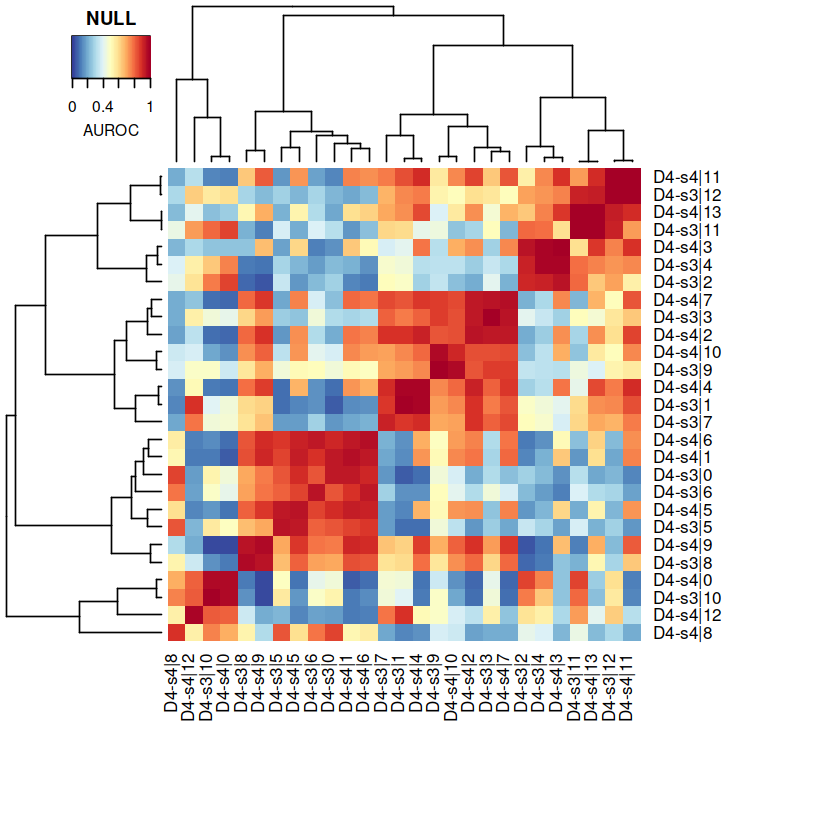

In [19]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
plotHeatmap(aurocsall, margins = c(10,10))
# dev.off()

In [20]:
topHits(aurocsall, dat = sce, study_id = sce$dataset, cell_type = sce$celltype,
        threshold = 0.9)

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type        
1  D4-s3|11            D4-s4|13            1.00       Reciprocal_top_hit
2  D4-s3|12            D4-s4|11            1.00       Reciprocal_top_hit
3  D4-s3|1             D4-s4|4             0.99       Reciprocal_top_hit
4  D4-s3|4             D4-s4|3             0.98       Reciprocal_top_hit
5  D4-s3|10            D4-s4|0             0.98       Reciprocal_top_hit
6  D4-s3|9             D4-s4|10            0.98       Reciprocal_top_hit
7  D4-s3|3             D4-s4|7             0.96       Reciprocal_top_hit
8  D4-s3|8             D4-s4|9             0.96       Reciprocal_top_hit
9  D4-s4|3             D4-s3|2             0.95       Above_0.9         
10 D4-s3|6             D4-s4|6             0.94       Reciprocal_top_hit
11 D4-s3|0             D4-s4|1             0.94       Reciprocal_top_hit
12 D4-s3|3             D4-s4|2             0.94       Above_0.9         
13 D4-s3|5             D4-s4|5             0.94       Reciprocal_top_hit
14 D4-s4|4             D4-s3|7             0.90       Above_0.9

In [ ]:
# save
# save(aurocsall, aurocs1v1, 
#      file = paste0(stages[id], '_', samples[id], '_Mantri_MN_scores.Rdata'))